In [4]:
from pathlib import Path
import pandas as pd

# This is much cleaner and avoids all syntax errors
file_path = Path("C:/Users\jains\Downloads\Crop_production_final.csv")
df = pd.read_csv(file_path)
print(df.head())

       State_Name Crop_Type       Crop    N   P   K    pH  rainfall  \
0  andhra pradesh    kharif     cotton  120  40  20  5.46    654.34   
1  andhra pradesh    kharif  horsegram   20  60  20  6.18    654.34   
2  andhra pradesh    kharif      jowar   80  40  40  5.42    654.34   
3  andhra pradesh    kharif      maize   80  40  20  5.62    654.34   
4  andhra pradesh    kharif      moong   20  40  20  5.68    654.34   

   temperature  Area_in_hectares  Production_in_tons  Yield_ton_per_hec  
0    29.266667            7300.0              9400.0           1.287671  
1    29.266667            3300.0              1000.0           0.303030  
2    29.266667           10100.0             10200.0           1.009901  
3    29.266667            2800.0              4900.0           1.750000  
4    29.266667            1300.0               500.0           0.384615  


In [5]:
print(df.shape)
df_clean = df[(df['Yield_ton_per_hec'] < 150 )& (df['Area_in_hectares'] >0.2) ].copy()
df_clean.shape

(96133, 12)


(96133, 12)

In [6]:
print(df.shape)
df_clean.drop(['Production_in_tons','Area_in_hectares'], axis=1, inplace=True)
print(df_clean.shape)
df_clean.head()

(96133, 12)
(96133, 10)


,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature,Yield_ton_per_hec
0,andhra pradesh,kharif,cotton,120,40,20,5.46,654.34,29.266667,1.287671
1,andhra pradesh,kharif,horsegram,20,60,20,6.18,654.34,29.266667,0.303030
2,andhra pradesh,kharif,jowar,80,40,40,5.42,654.34,29.266667,1.009901
3,andhra pradesh,kharif,maize,80,40,20,5.62,654.34,29.266667,1.750000
4,andhra pradesh,kharif,moong,20,40,20,5.68,654.34,29.266667,0.384615


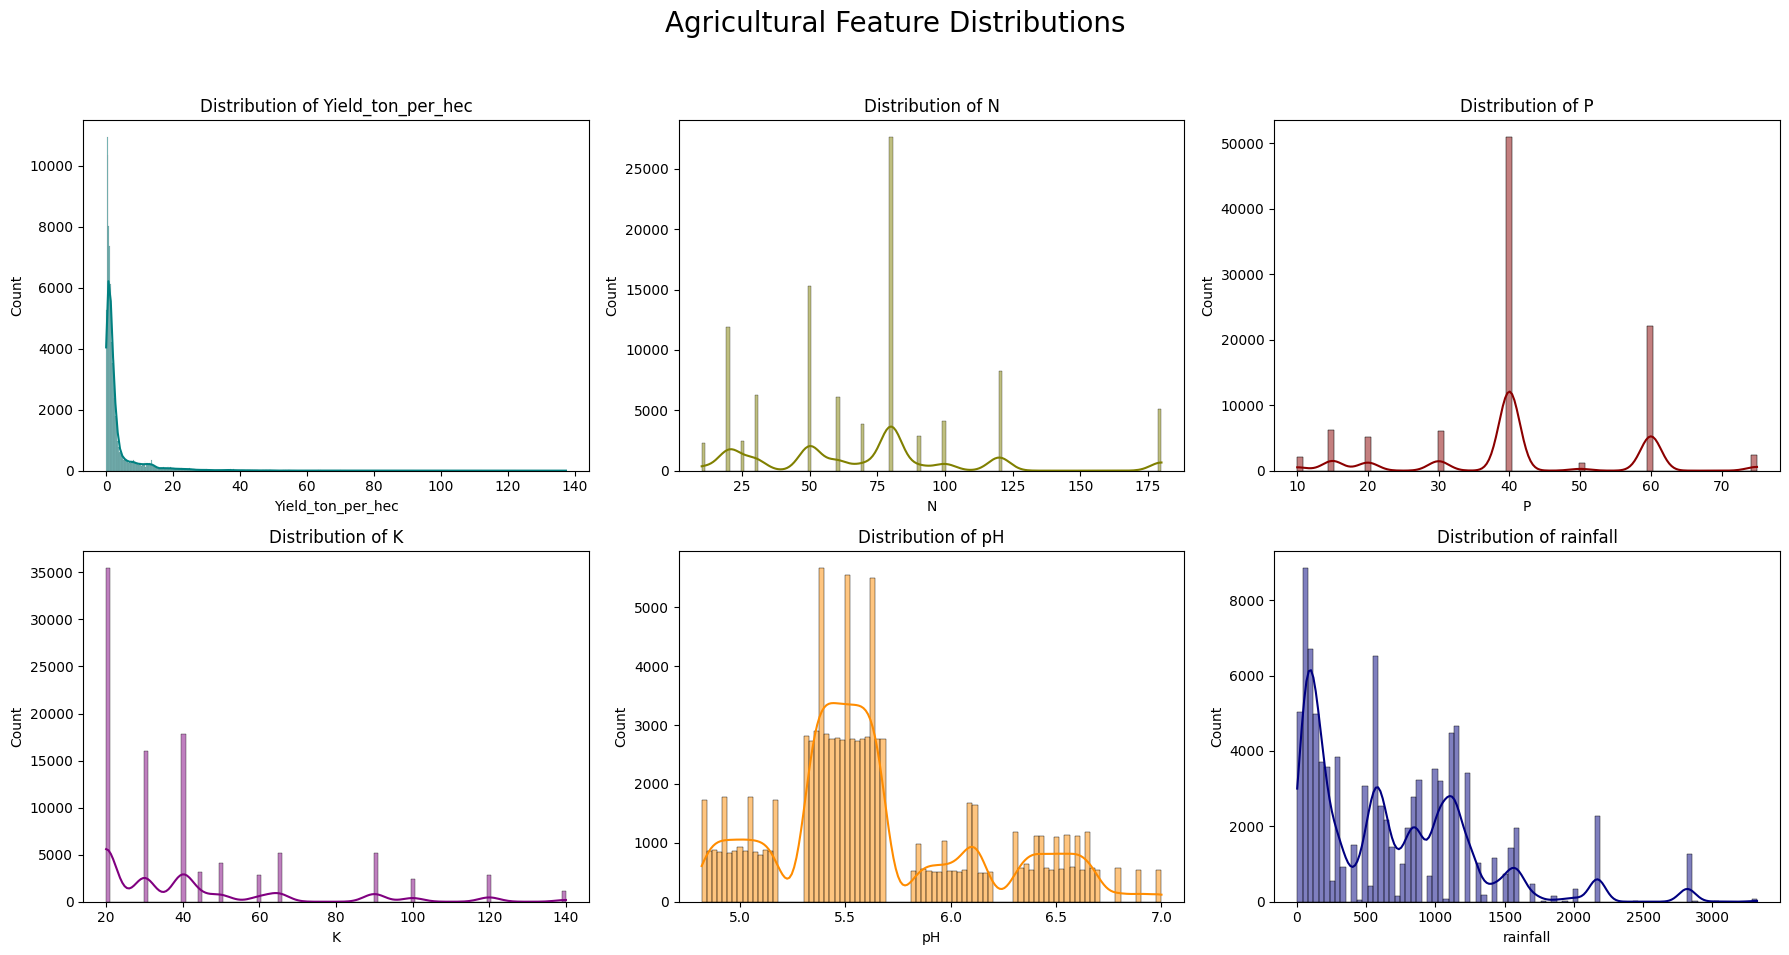

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup the figure and a 2x3 grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Agricultural Feature Distributions', fontsize=20)

# 2. List the columns you want to visualize
features = ['Yield_ton_per_hec', 'N', 'P', 'K', 'pH', 'rainfall']
colors = ['teal', 'olive', 'darkred', 'purple', 'darkorange', 'navy']

# 3. Use a loop to plot each one in its own subplot
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.histplot(df_clean[feature], kde=True, ax=axes[row, col], color=colors[i])
    axes[row, col].set_title(f'Distribution of {feature}')

# 4. Clean up the layout so titles don't overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X = df_clean.drop('Yield_ton_per_hec', axis=1) 
Y = df_clean['Yield_ton_per_hec']

#Perform the split
# test_size=0.2 means 20% goes to testing
# random_state=42 ensures you get the same split every time you run it
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Testing set size: {X_test.shape[0]} rows")

Training set size: 76906 rows
Testing set size: 19227 rows


In [9]:
X_train

,State_Name,Crop_Type,Crop,N,P,K,pH,rainfall,temperature
95760,uttarakhand,rabi,potato,180,60,90,4.86,169.82,14.600000
19591,jammu and kashmir,rabi,rapeseed,50,40,20,4.94,293.36,14.700000
88385,uttar pradesh,kharif,maize,80,40,20,5.60,579.75,34.010000
37023,uttar pradesh,rabi,onion,120,60,65,6.16,75.32,22.676000
42798,odisha,rabi,rapeseed,50,40,20,5.04,167.38,23.560000
...,...,...,...,...,...,...,...,...,...
6265,haryana,rabi,wheat,60,30,30,6.40,41.30,21.704000
54886,jammu and kashmir,kharif,maize,80,40,20,5.54,516.68,27.866667
76820,jammu and kashmir,rabi,garlic,50,10,60,5.60,293.36,14.700000
860,bihar,rabi,maize,80,40,20,5.34,87.20,23.106000


In [10]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# 1. Define the Transformers
# FunctionTransformer for the extreme right-skew (Rainfall & Area)
log_transformer = FunctionTransformer(np.log1p, validate=True)

# PowerTransformer with Yeo-Johnson for multimodal/spiky data (N, P, K)
# This helps normalize those 'spikes' we saw in your histograms
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

# Standard scaler for the variables that are already fairly normal (pH, temperature)
scaler = StandardScaler()

# OrdinalEncoder for categorical variables
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# 2. Build the ColumnTransformer
# This is the "brain" that applies the right math to the right columns
preprocessor = ColumnTransformer(
    transformers=[
        ('log_group', log_transformer, ['rainfall']),
        ('power_group', power_transformer, ['N', 'P', 'K']),
        ('scale_group', scaler, ['pH', 'temperature']),
        ('cat_group', encoder, ['State_Name', 'Crop_Type', 'Crop'])
    ],
    remainder='passthrough'  # Keeps any other columns as they are
)

# 3. Usage Pattern
# Assuming X_train is your dataframe with the original 10 features
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert back to DataFrame if you want to inspect the names
feature_names = (['rainfall'] + ['N', 'P', 'K'] + 
                 ['pH', 'temp'] + ['State', 'Type', 'Crop'])
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)

print("Pre-processing complete. Your data is now normalized and ready for XGBoost!")
print(X_train_df.head())

Pre-processing complete. Your data is now normalized and ready for XGBoost!
   rainfall         N         P         K        pH      temp  State  Type  \
0  5.140610  2.175197  1.276267  1.532405 -1.589086 -2.615566   31.0   1.0   
1  5.684804 -0.369831 -0.110673 -1.138479 -1.426579 -2.594058   12.0   1.0   
2  6.364320  0.413480 -0.110673 -1.138479 -0.085894  1.559041   30.0   0.0   
3  4.334935  1.221755  1.276267  1.179776  1.051657 -0.878620   30.0   1.0   
4  5.126223 -0.369831 -0.110673 -1.138479 -1.223445 -0.688493   22.0   1.0   

   Crop  
0  14.0  
1  16.0  
2  11.0  
3  13.0  
4  16.0  


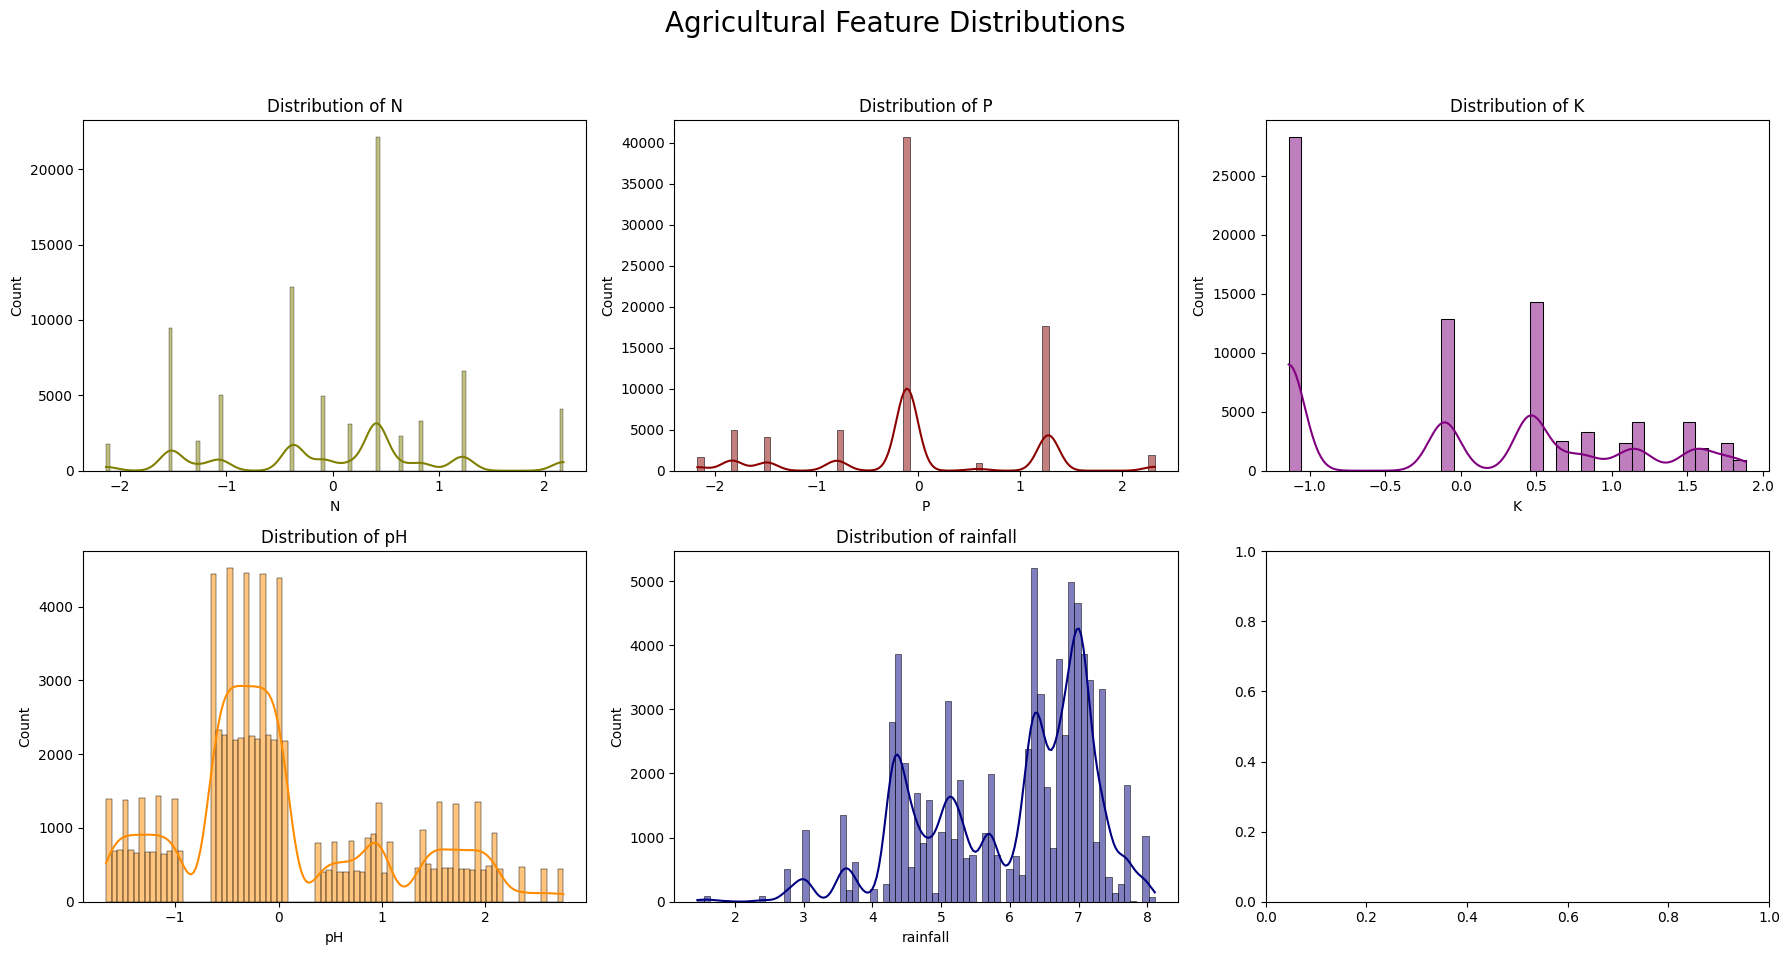

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup the figure and a 2x3 grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Agricultural Feature Distributions', fontsize=20)

# 2. List the columns you want to visualize
features = [ 'N', 'P', 'K', 'pH', 'rainfall']
colors = [ 'olive', 'darkred', 'purple', 'darkorange', 'navy']

# 3. Use a loop to plot each one in its own subplot
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.histplot(X_train_df[feature], kde=True, ax=axes[row, col], color=colors[i])
    axes[row, col].set_title(f'Distribution of {feature}')

# 4. Clean up the layout so titles don't overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import time

# 1. Initialize the Model
# n_estimators: Number of trees. 100 is a great balance of speed and accuracy.
# random_state: Set to 42 (or any number) so your results are the same every time.
# n_jobs: -1 tells your PC to use ALL its CPU cores (much faster for 100k rows!).
rf_model = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)

# 2. Start the Timer (Good for monitoring performance in VS Code)
start_time = time.time()

# 3. Train (Fit) the Model
print("Training the Random Forest... please wait.")
rf_model.fit(X_train_transformed, y_train)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# 4. Make Predictions
y_pred = rf_model.predict(X_test_transformed)

# 5. Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f} tons")
print(f"R-squared Score: {r2:.4f}")

Training the Random Forest... please wait.
Training completed in 0.18 seconds.
Mean Absolute Error: 0.48 tons
R-squared Score: 0.8070


In [10]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error

def objective(trial):
    # 1. Suggest Hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # CPU Optimization Settings
        'n_jobs': -1,            # Use all CPU cores
        'tree_method': 'hist',   # Best for CPU efficiency
        'random_state': 42
    }

    # 2. Initialize and Train
    # Using the X_train_transformed we built with the ColumnTransformer
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_transformed, y_train)

    # 3. Evaluate using MSE
    preds = model.predict(X_test_transformed)
    mae = mean_absolute_error(y_test, preds)
    return mae

# 4. Create and Run the Study
# We minimize MSE to get the most accurate yield predictions
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f"Best MSE Score: {study.best_value}")
print(f"Best Hyperparameters: {study.best_params}")

e:\coding\ML_hackthon_agri\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2026-02-05 05:14:49,107] A new study created in memory with name: no-name-da8c884c-119d-4b4c-9eaa-21ae7c6770b7
[I 2026-02-05 05:14:50,174] Trial 0 finished with value: 0.5026105845865875 and parameters: {'n_estimators': 951, 'max_depth': 5, 'learning_rate': 0.016064142355325637, 'subsample': 0.7541225692253338, 'colsample_bytree': 0.8709837678571768}. Best is trial 0 with value: 0.5026105845865875.
[I 2026-02-05 05:14:51,299] Trial 1 finished with value: 0.510859797780831 and parameters: {'n_estimators': 1350, 'max_depth': 4, 'learning_rate': 0.02019753887509275, 'subsample': 0.9137326962712696, 'colsample_bytree': 0.9159242854120935}. Best is trial 0 with value: 0.5026105845865875.
[I 2026-02-05 05:14:52,530] Trial 2 finished with 

Best MSE Score: 0.4467624429692662
Best Hyperparameters: {'n_estimators': 369, 'max_depth': 9, 'learning_rate': 0.027408437018010656, 'subsample': 0.996503137727649, 'colsample_bytree': 0.7261189221516808}


In [12]:
import numpy as np
import optuna
import xgboost as xgb
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

def objective(trial):
    # 1. Hyperparameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # CPU Settings
        'n_jobs': -1,
        'tree_method': 'hist',
        'random_state': 42
    }

    # 2. Wrap the XGBoost model to handle Log(y) automatically
    base_regressor = xgb.XGBRegressor(**param)
    
    # func=np.log1p transforms y to log(1+y)
    # inverse_func=np.expm1 converts it back to tons automatically
    model = TransformedTargetRegressor(
        regressor=base_regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # 3. Train on transformed data
    model.fit(X_train_transformed, y_train)

    # 4. Predict and Evaluate
    # Predictions are already back in 'tons' because of the wrapper
    preds = model.predict(X_test_transformed)
    mae = mean_absolute_error(y_test, preds)
    return mae

# 5. Run the Study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=75)

print(f"Best MSE: {study.best_value}")
print(f"Best Params: {study.best_params}")

[I 2026-02-05 05:17:10,400] A new study created in memory with name: no-name-4034ae0f-beb6-4681-b2b1-d9fd6e807c44
[I 2026-02-05 05:17:11,453] Trial 0 finished with value: 0.4653225682060662 and parameters: {'n_estimators': 1207, 'max_depth': 4, 'learning_rate': 0.04798402514627599, 'subsample': 0.7519220720914176, 'colsample_bytree': 0.9329764441891394}. Best is trial 0 with value: 0.4653225682060662.
[I 2026-02-05 05:17:11,921] Trial 1 finished with value: 0.7188851421877823 and parameters: {'n_estimators': 563, 'max_depth': 3, 'learning_rate': 0.012215821732435916, 'subsample': 0.813070540014123, 'colsample_bytree': 0.823105874550897}. Best is trial 0 with value: 0.4653225682060662.
[I 2026-02-05 05:17:12,491] Trial 2 finished with value: 0.5973603970774626 and parameters: {'n_estimators': 671, 'max_depth': 4, 'learning_rate': 0.01374193130964904, 'subsample': 0.8322193626203935, 'colsample_bytree': 0.9907015346079403}. Best is trial 0 with value: 0.4653225682060662.
[I 2026-02-05 05

Best MSE: 0.44273708992161886
Best Params: {'n_estimators': 1354, 'max_depth': 6, 'learning_rate': 0.04299736603263499, 'subsample': 0.9340636284838021, 'colsample_bytree': 0.6042527007928613}


In [15]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Best parameters from your Optuna study
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Corrected parameters (using colons)
best_params = {
    'n_estimators': 1354, 
    'max_depth': 6, 
    'learning_rate': 0.04299736603263499, 
    'subsample': 0.9340636284838021, 
    'colsample_bytree': 0.6042527007928613,
    'n_jobs': -1,            # Maximize CPU usage
    'tree_method': 'hist',   # Fast CPU training
    'random_state': 42
}

# 2. Setup the "Translator" Model
base_xgb = xgb.XGBRegressor(**best_params)
final_model = TransformedTargetRegressor(
    regressor=base_xgb,
    func=np.log1p,      # log(1+y) to normalize right-skew
    inverse_func=np.expm1 # Convert back to tons
)

# 3. Fit on the transformed training data
final_model.fit(X_train_transformed, y_train)

# 4. Predict and Evaluate
y_pred = final_model.predict(X_test_transformed)

print(f"--- Final Model Performance ---")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f} tons")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
# 2. Setup the "Translator" Model (TransformedTargetRegressor)
base_xgb = xgb.XGBRegressor(**best_params)
final_model = TransformedTargetRegressor(
    regressor=base_xgb,
    func=np.log1p,      # Log target for training
    inverse_func=np.expm1 # Convert back to tons for evaluation
)

# 3. Fit on the transformed training data
final_model.fit(X_train_transformed, y_train)

# 4. Predict and Evaluate on test data
y_pred = final_model.predict(X_test_transformed)

print(f"--- Final Model Performance ---")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f} tons")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

--- Final Model Performance ---
R2 Score: 0.8341
MAE: 0.4427 tons
MSE: 0.6146
--- Final Model Performance ---
R2 Score: 0.8341
MAE: 0.4427 tons
MSE: 0.6146


C:\Users\jains\AppData\Local\Temp\ipykernel_29420\1435778685.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')


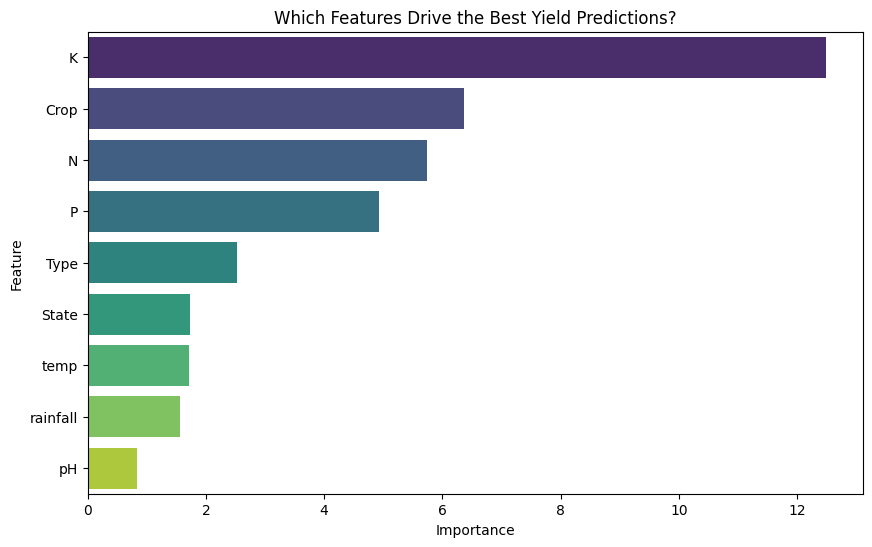

In [16]:
# 1. Get the underlying XGBoost model from the wrapper
booster = final_model.regressor_.get_booster()
importance = booster.get_score(importance_type='gain') # Gain = Contribution to accuracy

# 2. Map back to your column names (Ensure this matches your ColumnTransformer order)
feature_names = (['rainfall'] + ['N', 'P', 'K'] + 
                 ['pH', 'temp'] + ['State', 'Type', 'Crop'])

# 3. Create a clean mapping
mapped_importance = {feature_names[int(k[1:])]: v for k, v in importance.items()}
fi_df = pd.DataFrame(list(mapped_importance.items()), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x='Importance', y='Feature', palette='viridis')
plt.title('Which Features Drive the Best Yield Predictions?')
plt.show()

In [33]:
# Create the dataset for Low Yield (< 10)
df_low = df_clean[df_clean['Yield_ton_per_hec'] < 10].copy()

# Create the dataset for High Yield (>= 10) 
# Note: Usually we use >= to ensure the value 10 isn't lost!
df_high = df_clean[df_clean['Yield_ton_per_hec'] >= 10].copy()


# Describe both
print("--- Low Yield (< 10) Stats ---")
print(df_low['Yield_ton_per_hec'].describe())

print("\n--- High Yield (>= 10) Stats ---")
print(df_high['Yield_ton_per_hec'].describe())

--- Low Yield (< 10) Stats ---
count    86369.000000
mean         1.783259
std          1.905191
min          0.000514
25%          0.551020
50%          1.150246
75%          2.197671
max          9.999327
Name: Yield_ton_per_hec, dtype: float64

--- High Yield (>= 10) Stats ---
count    9764.000000
mean       20.123963
std        11.816584
min        10.000000
25%        12.466250
50%        15.728381
75%        23.439073
max       137.400000
Name: Yield_ton_per_hec, dtype: float64


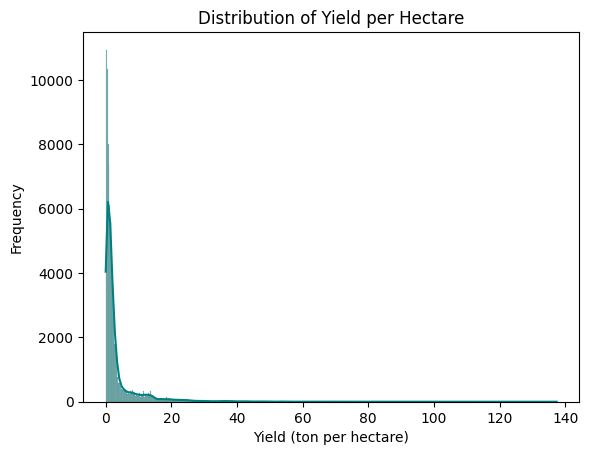

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting Histogram with a KDE line overlay
sns.histplot(df_clean['Yield_ton_per_hec'], kde=True, color='teal')

plt.title('Distribution of Yield per Hectare')
plt.xlabel('Yield (ton per hectare)')
plt.ylabel('Frequency')
plt.show()

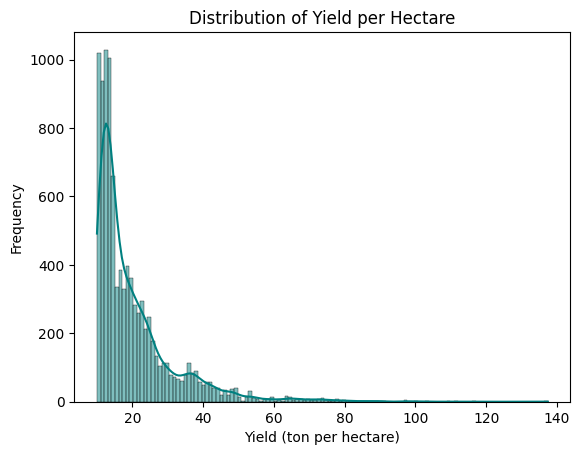

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting Histogram with a KDE line overlay
sns.histplot(df_high['Yield_ton_per_hec'], kde=True, color='teal')

plt.title('Distribution of Yield per Hectare')
plt.xlabel('Yield (ton per hectare)')
plt.ylabel('Frequency')
plt.show()

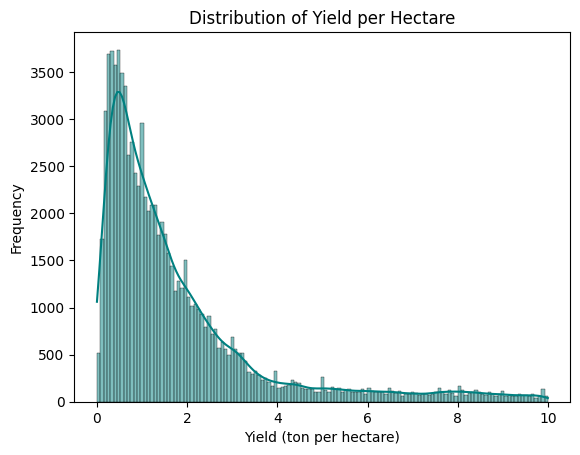

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting Histogram with a KDE line overlay
sns.histplot(df_low['Yield_ton_per_hec'], kde=True, color='teal')

plt.title('Distribution of Yield per Hectare')
plt.xlabel('Yield (ton per hectare)')
plt.ylabel('Frequency')
plt.show()